## KNN Regression

A main goal of regression is estimating 

$$
P(y|X)
$$

Our previous approach to understanding this conditional probability was to define a linear regression model

$$
P(y|X) \sim N[f(X),\sigma^{2}].
$$

The above model had many advantages.
The regression parameters $(\beta)$ were easy to compute, the association between $y$ and $X$ followed a functional form $f$.

But there are disadvantages too.
A model like the above makes strong assumption about the form of our model.
We restrict the types of models we can fit by prespecifying $f$.

Nonparametric models broaden the class of models we can fit.
These models do not assume our function $f$ is the same everywhere, determined by a single set of parameters.
Instead, our model and parameters that define the model are allowed to grow with the data. 

*K nearest neighbor (KNN) regression* is one type of nonparametric model.
KNN regression estimates f(x) by looking at data points close to the value $x$ and then averaging the response values.
For example, we can make a prediction given a point $x$ by the following
$$
f(x) = \frac{1}{|N(x)|}\sum_{i \in N(x)} y_{i}
$$
where $N(x)$ is a *neighborhood* of (x_{i},y_{i}) data points near the value $x$ and $|N(x)|$ counts the total number of data points in the neighborhood.

We can compare simple linear, polynomial, and KNN regression by looking at a dataset.

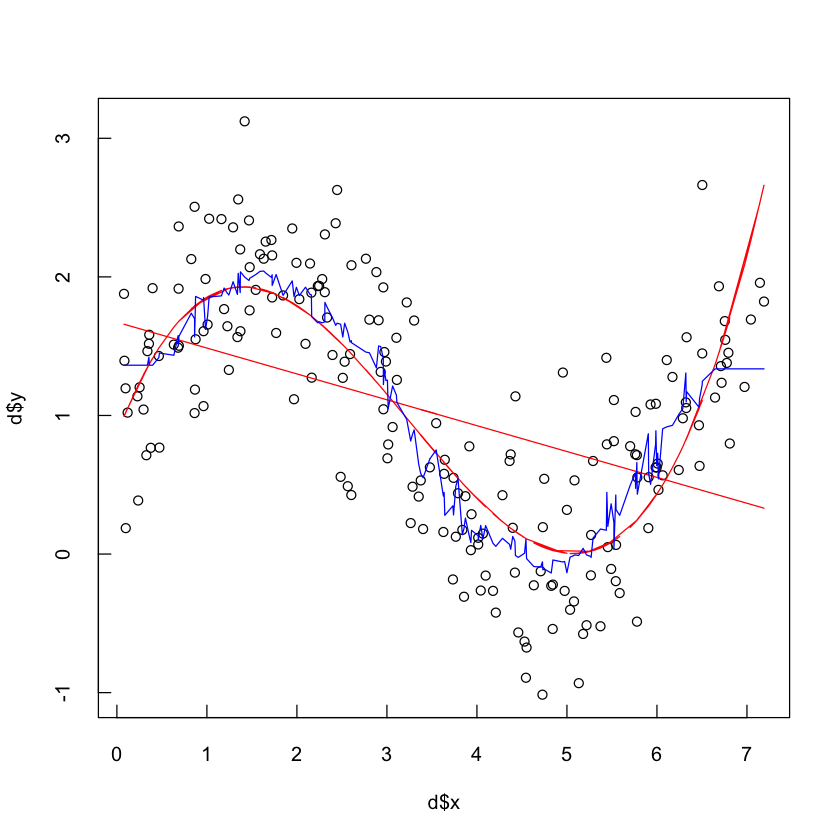

In [58]:
d = read.csv('./dataSet1.csv')
plot(d$x,d$y,tck=0.02)

#SLR
SLR = lm(y~x,data=d)
predictions = predict(SLR)
lines(d$x,predictions,col='red')

#PR
PR = lm(y~x+I(x^2)+I(x^3),data=d)
predictions = predict(PR)
lines(d$x,predictions,col='red')

#KNN regression
library(FNN)
d = d[order(d$x),] # sort the data frame by the variable X
KNN = knn.reg(train = d, test=d, y = d$y, k = 25) #FIT KNN MODEL
lines(d$x,KNN$pred,col='blue')

## Neighborhood

A neighborhood at a point $x$ defines a set of points that are considered close to $x$.
In order to define close, we will need to define a distance metric.

A distance metric is a function $d(x,y)$ that takes two points and returns a number on the real line.
The distance between a a point and itself $d(x,x)$ must equal 0.
The distance should also be symmetric or $d(x,y)=d(y,x)$.
Intuitively, small distance values mean points are close and large values mean points are far away.

### Euclidean distance
The Euclidean distance between two vectors $x$ and $y$ equals

$$
    d(x,y) = \left[\sum_{i} (x_{i}-y_{i})^2\right]^{1/2}
$$

or in vector notation

$$
    d(x,y) = \left[ (x-y)'(x-y)\right]^{1/2}
$$

For example,

In [147]:
x = 1

euclideanDistance = function(x,y){
    return( sqrt(t(x-y)%*%(x-y)) )
}

print("Single Numbers")
distance = euclideanDistance(c(1),c(4))
print(distance)

print("Vectors")
distance = euclideanDistance(c(1,2,3),c(4,5,6))
print(distance)

[1] "Single Numbers"
     [,1]
[1,]    3
[1] "Vectors"
         [,1]
[1,] 5.196152


The above KNN regression uses Euclidean distance to define neighborhoods.

## Bias - variance tradeoff

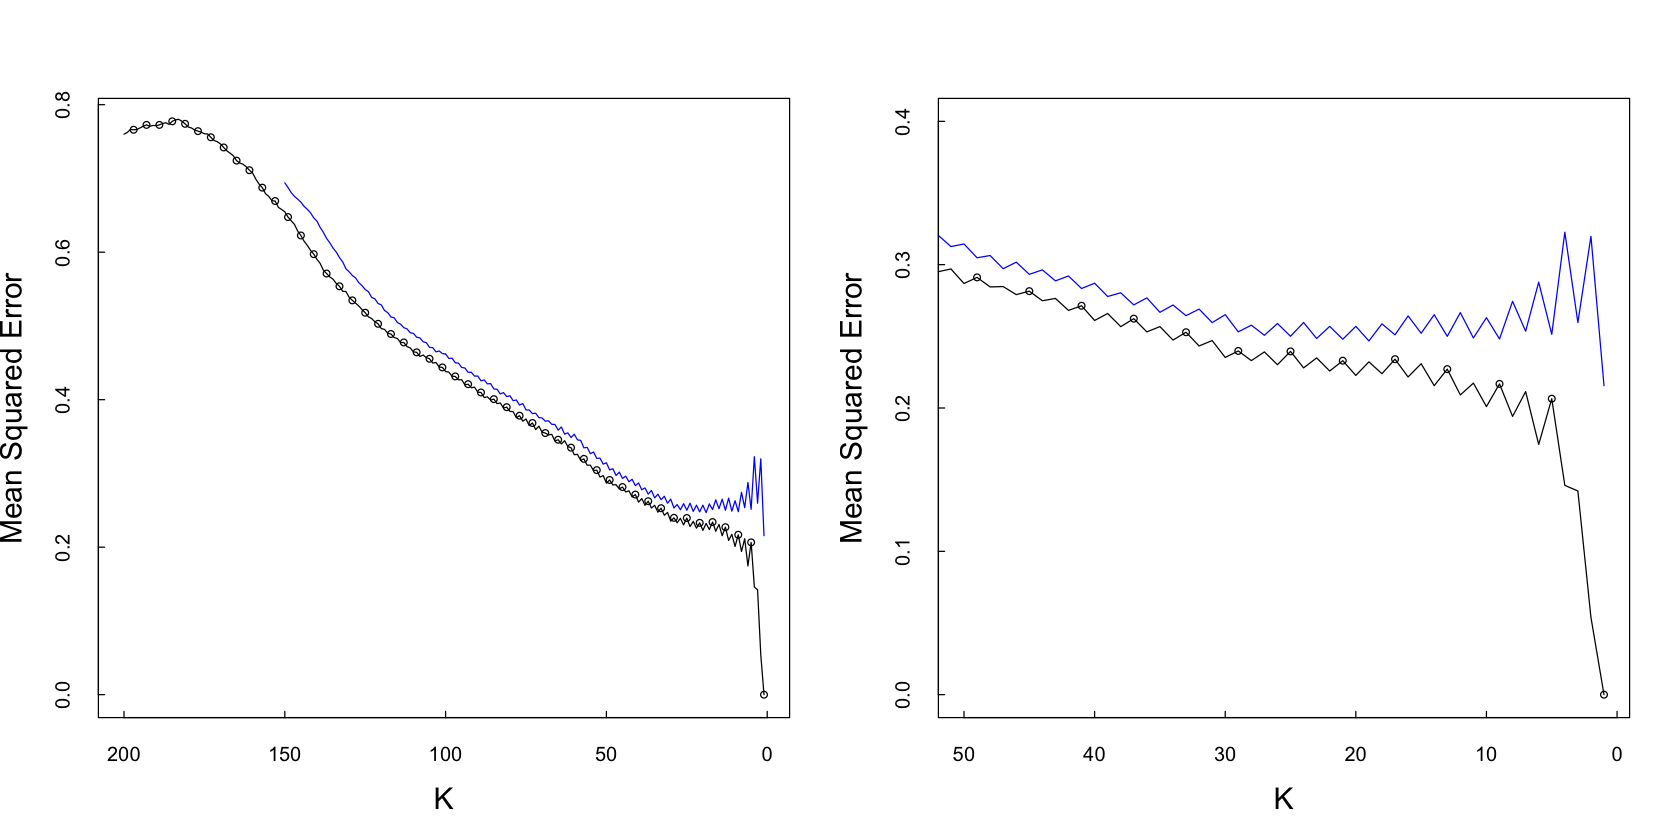

In [146]:
d = read.csv('./dataSet1.csv')
N = nrow(d)

#KNN regression
library(FNN)

#two plots
options(repr.plot.width=7*2.0,repr.plot.height=7)
par(mfrow=c(1,2))

#TRAINING MSE
MSEs = rep(0,200)
for (k in 1:200){
    KNN = knn.reg(train = d, test=d, y = d$y, k = k)
    MSE = t(KNN$pred - d$y)%*%(KNN$pred - d$y)/N
    MSEs[k] = MSE
}
results = data.frame("k"=1:200,"MSE"=MSEs)

plot(results$k[seq(1,200,4)],results$MSE[seq(1,200,4)]
     ,xlim=c(200,1)
     ,tck=0.01
     ,xlab='K'
     ,ylab='Mean Squared Error'
     ,cex=0.75
     ,cex.lab=1.5)
lines(results$k,results$MSE,xlim=c(200,1))

#TESTING MSE
Folds = 20
dataFolds = split(d,1:Folds)


cvErrors = rep(0,150)
for(k in 1:150){
    
    MSEs = rep(0,Folds)
    for(i in 1:Folds){
        testSet = dataFolds[[i]]
        N = nrow(testSet)

        exceptI = setdiff(1:Folds,i)
        trainingSet = do.call(rbind,dataFolds[exceptI])

        KNN = knn.reg(train = trainingSet
                      ,test=testSet
                      ,y = trainingSet$y
                      ,k = k)
        MSE = t(KNN$pred - testSet$y)%*%(KNN$pred - testSet$y)/N
        MSEs[i] = MSE
    }
    cvErrorForSingleK = mean(MSEs)
    cvErrors[k] = cvErrorForSingleK
}
lines(1:150,cvErrors,col='blue')


#SECOND PLOT
plot(results$k[seq(1,200,4)],results$MSE[seq(1,200,4)]
     ,xlim=c(50,1)
     ,ylim =c(0,0.4)
     ,tck=0.01
     ,xlab='K'
     ,ylab='Mean Squared Error'
     ,cex=0.75
     ,cex.lab=1.5)
lines(results$k,results$MSE,xlim=c(200,1))
lines(1:150,cvErrors,col='blue')

The training MSE decreases as we make our neighborhood size smaller.
The model considers fewer points to create an average and is able to fit more complicated models.
When K is small our model will have lower bias.

We pay a penalty for small neighborhoods and lower bias.
If we reduce K to values smaller than 20, our test MSE begins to increase.
Our model is beginning to overfit our training data.